In [1]:
import numpy as np
import pandas as pd
import os
from itertools import groupby
from operator import itemgetter
from aicsimageio.readers import OmeTiffReader
from aicsimageio.writers import OmeTiffWriter
from CustomFunctions import RotateImage
import multiprocessing
from CustomFunctions.PCvisualization import interpolate_contour_shapes, mesh_from_bins, interpolate_transitions_by_time, interpolate_transitions_by_distance
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
from cmocean import cm
import matplotlib
from matplotlib.animation import FuncAnimation 
import matplotlib.pyplot as plt

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


In [2]:
########## find a cell of interest ###########
savedir = 'E:/Aaron/Combined_Confocal_PCA_nospeedoutliers/'
infrsavedir = savedir + 'Inframe_Videos/'

TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

#lmax used to generate the shcoeffs
lmax = 10

#time interval for movies
time_interval = 10

#get PC bins
centers = pd.read_csv(savedir + 'PC_bin_centers.csv', index_col=0)
PC1bins = centers.PC1.to_numpy()
PC2bins = centers.PC2.to_numpy()
#get nbins from range of binranges
nbins = len(centers)


#find the length of cell consecutive frames
results = []
for i, cells in TotalFrame.groupby('CellID'):
    cells = cells.sort_values('frame').reset_index(drop = True)
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)
    maxrun = max([len(l) for l in runs])
    actualrun = max(runs, key=len, default=[])
    results.append([i, maxrun, actualrun])
#find
stdf = pd.DataFrame(results, columns = ['CellID','length_of_run','actual_run']).sort_values('length_of_run', ascending=False).reset_index(drop=True)
stdf.head(30)

,CellID,length_of_run,actual_run
0,20231108_488EGFP-CAAX_0.1percentDMSO_2_cell_4,181,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_28,151,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,20231113_488EGFP-CAAX_0.1percentDMSO_3_cell_20,131,"[35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42...."
3,20231106_488EGFP-CAAX_10uMCK666_1_cell_19,129,"[52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59...."
4,20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_1,121,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
5,20231122_488EGFP-CAAX_3mA_37C_2_cell_23,119,"[155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161..."
6,20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell_27,119,"[62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69...."
7,20231019_488EGFP-CAAX_1_cell_70,118,"[153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159..."
8,20231020_488EGFP-CAAX_1_cell_9,114,"[77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84...."
9,20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell_30,113,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [4]:
########## GET THE SH COEFFS FOR THE TOP 10 LONGEST RUNS TO 
########## SEND TO ALEX AT THE ALLEN FOR OMD
top10 = []
for i in range(10):
    #select cell from list above
    row = stdf.loc[i]
    print(row.CellID)
    #get the data related to this run of this cell
    top10.append(TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame.isin(row.actual_run))].sort_values('frame').reset_index(drop=True))

alexframe = pd.concat(top10)
    
digitframe = pd.read_csv(savedir + 'Shape_Metrics_with_Digitized_PCs.csv')


shframe = digitframe[digitframe.cell.isin(alexframe.cell.to_list())]
colz = [x for x in digitframe.columns.to_list() if 'shco' in x]
colz.extend(['CellID','frame_x'])
midalex = shframe.merge(alexframe,left_on='cell',right_on='cell')
finalalex = midalex[colz]
finalalex = finalalex.rename(columns={'frame_x':'frame'})
finalalex = finalalex.sort_values(['CellID','frame'])
finalalex.to_csv('C:/Users/Aaron/Desktop/alignedNeutrophil_SHCoeffs.csv')

20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_6
20231106_488EGFP-CAAX_10uMCK666_2_cell_12
20231108_488EGFP-CAAX_0.1percentDMSO_2_cell_4
20231113_488EGFP-CAAX_10uMParaNitroBleb_1_cell_14
20231122_488EGFP-CAAX_3mA_37C_1_cell_90
20231106_488EGFP-CAAX_0.05percentDMSO_2_cell_12
20231113_488EGFP-CAAX_0.1percentDMSO_3_cell_20
20231106_488EGFP-CAAX_10uMCK666_1_cell_19
20231031_488EGFP-CAAX_0.1percentDMSO_2_cell_20
20231106_488EGFP-CAAX_0.05percentDMSO_1_cell_25


In [15]:
#### select cell from list above
row = stdf.loc[12]
print(row.CellID)
#get the data related to this run of this cell
data = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame.isin(row.actual_run))].sort_values('frame').reset_index(drop=True)

20231106_488EGFP-CAAX_10uMCK666_1_cell_7


In [76]:
############### get animated PCs without interpolating the transitions #############
from CustomFunctions.PCvisualization import animate_PCs
import pickle as pk

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/PC meshes/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(savedir+"pca.pkl",'rb'))
#define which PCs to incorporate into the view
whichpcs = [1,2]

for r in row.actual_run:
    current = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame==r)]
    PCs = [current[f'PC{whichpcs[0]}'],current[f'PC{whichpcs[1]}']]
    cursavedir = specificdir + f'frame_{int(r)}_PC{whichpcs[0]}_and_{whichpcs[1]}_mesh.vtp'
#     rotations = current[['Euler_angles_X','Euler_angles_Y','Euler_angles_Z','Width_Rotation_Angle']].values[0]
    animate_PCs(avgpcs,
                whichpcs,
                PCs,
                pca,
                cursavedir,
                lmax,)
#                rotations,)


In [61]:
############### get animated PCs WITH interpolated transitions #############


#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/interpolated PC meshes/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)

#get the average of each PC
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and '_' not in x]].mean().to_numpy()
#open the actual pca file used to analyze this dataset
pca = pk.load(open(savedir+"pca.pkl",'rb'))
#define which PCs to incorporate into the view
whichpcs = [1,2]

#get transition trajectory
bintraj = data[['PC1','PC2']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_time(bintraj,5)


for i in interarray:
    PCs = i[1:].copy()
    cursavedir = specificdir +'frame_'+str(format(i[0],'.5f'))+f'_PC{whichpcs[0]}_and_{whichpcs[1]}_mesh.vtp'
    animate_PCs(avgpcs,
                whichpcs,
                PCs,
                pca,
                cursavedir,
                lmax,)



In [19]:
############# reconstruct "in frame" video of cell WITH alignment to frame of reference #############


#define directory with the actual images
imdir = 'D:/Aaron/Data/Galvanotaxis_Confocal_40x_30C_10s/Processed_Data/'

#reconstruct image names
imnames = [row.CellID+'_frame_'+str(int(r))+'_raw.tiff' for r in row.actual_run]
#read all the images into a list
imlist = [OmeTiffReader(imdir+i).data for i in imnames]


#rotate all the raw images so they're facing to the right, like the PCs
if __name__ ==  '__main__':
    pool = multiprocessing.Pool(processes=60)
    results = []
    for i, r in enumerate(row.actual_run):
        current = TotalFrame[(TotalFrame.CellID==row.CellID) & (TotalFrame.frame==r)]
        pool.apply_async(RotateImage.rotate_tiff_mp, args = (
            i,
            imlist[i],
            current.Euler_angles_X.values[0],
            current.Euler_angles_Z.values[0],
            current.Width_Rotation_Angle.values[0],
            True,
            ),
            callback = collect_results)
pool.close()
pool.join()

imlist = [results[x][1] for x in range(len(results))]


#get the maximum xyz dimensions of the entire list of images
shapemax = np.max(np.array([s.shape for s in imlist]))
#pad each image to match the same, cubic, 3D array shape
padlist = []
for i, im in enumerate(imlist):
    padlist.append(RotateImage.match_shape(im,list(im.shape[:2])+[shapemax]*3))
#combine all of the expanded images
combinedim = np.concatenate(padlist)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
#save the inframe combined image
OmeTiffWriter.save(combinedim, specificdir+'Cell_FoR_raw.ome.tiff', dim_order='TCZYX')

In [68]:
len(meshfl)/40, 116/8

(14.375, 14.5)

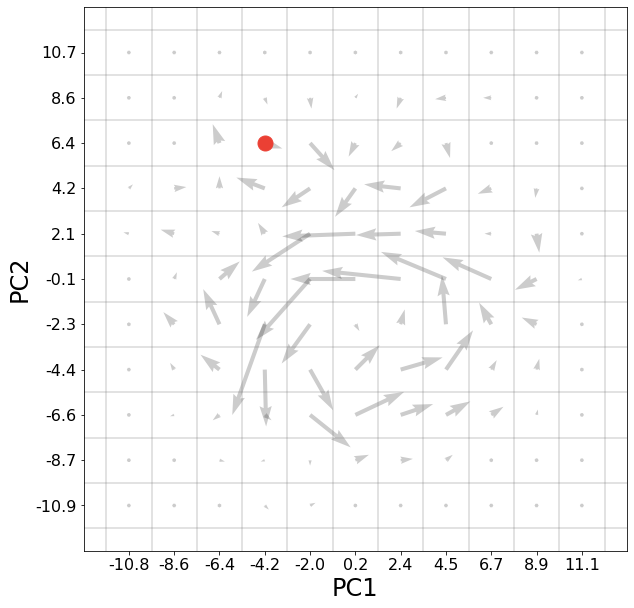

In [209]:
########## animate the PC transition trajectory ##############


#open the vector field relating to this sample
trans_rate_df = pd.read_csv(savedir + 'PC1-PC2_binned_transition_rates_separated.csv', index_col=0)
trans_rate_df = trans_rate_df[trans_rate_df.Migration_Mode == row.Migration_Mode]

nbins = 11

# inverse scale for arrows
scale = 0.0005

#get the interpolated points just in case I haven't calculated them yet
bintraj = data[['PC1bins','PC2bins']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_time(bintraj, 20)

#make fig
fig, ax = plt.subplots(figsize = (10,10))


#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(interarray[0,1],interarray[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, interarray):
    point.set_data([interarray[i,1]], [interarray[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(interarray))), fargs = (interarray,))
plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + '_plotanimation_PC1-PC2.mp4', fps=40, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


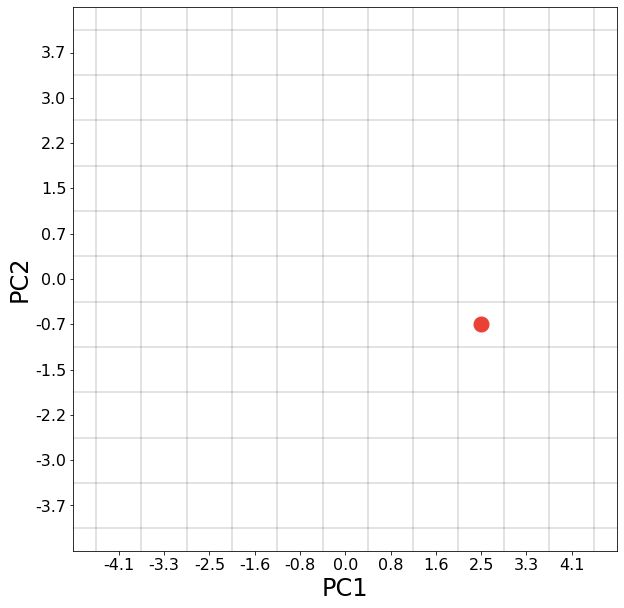

In [16]:
########## animate the PC transition trajectory DRAW THE LINE AS THROUGH TIME ##############


#open the centers of the binned PCs
centers = pd.read_csv(savedir+'PC_bin_centers.csv', index_col=0)


nbins = 11

# inverse scale for arrows
scale = 0.0005

#get the interpolated points just in case I haven't calculated them yet
bintraj = data[['PC1bins','PC2bins']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_time(bintraj.astype(float), 20)

#make fig
fig, ax = plt.subplots(figsize = (10,10))


#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines


    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC1.to_list()], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC2.to_list()], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(interarray[0,1],interarray[0,2], marker="o", color = '#eb4034', markersize = 15)
line, = ax.plot(interarray[:,1], interarray[:,2])
# make function for updating point position
def animate(i, interarray):
    point.set_data([interarray[i,1]], [interarray[i,2]])
    line.set_data(interarray[:i+1, 1], interarray[:i+1, 2])
    return point, line

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(interarray))), fargs = (interarray,))
plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + '_plotanimation_PC1-PC2.mp4', fps=40, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [7]:
########## animate the PC transition trajectory 
########## DRAW THE LINE AS THROUGH TIME WITH COLOR CHANGE 

#open the centers of the binned PCs
centers = pd.read_csv(savedir+'PC_bin_centers.csv', index_col=0)


nbins = 11


#get the interpolated points just in case I haven't calculated them yet
bintraj = data[['PC1bins','PC2bins']].to_numpy()
#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_distance(bintraj)
interarray[np.where(interarray[:,0]<=2)]


array([[0.00000000e+00, 0.00000000e+00, 9.00000000e+00, 5.00000000e+00],
       [0.00000000e+00, 6.84215759e-04, 9.07144257e+00, 5.07144257e+00],
       [0.00000000e+00, 1.36843152e-03, 9.14288515e+00, 5.14288515e+00],
       [0.00000000e+00, 2.05264728e-03, 9.21432772e+00, 5.21432772e+00],
       [0.00000000e+00, 2.73686303e-03, 9.28577029e+00, 5.28577029e+00],
       [0.00000000e+00, 3.42107879e-03, 9.35721287e+00, 5.35721287e+00],
       [0.00000000e+00, 4.10529455e-03, 9.42865544e+00, 5.42865544e+00],
       [0.00000000e+00, 4.78951031e-03, 9.50009802e+00, 5.50009802e+00],
       [0.00000000e+00, 5.47372607e-03, 9.57154059e+00, 5.57154059e+00],
       [0.00000000e+00, 6.15794183e-03, 9.64298316e+00, 5.64298316e+00],
       [0.00000000e+00, 6.84215759e-03, 9.71442574e+00, 5.71442574e+00],
       [0.00000000e+00, 7.52637335e-03, 9.78586831e+00, 5.78586831e+00],
       [0.00000000e+00, 8.21058910e-03, 9.85731088e+00, 5.85731088e+00],
       [0.00000000e+00, 8.89480486e-03, 9.92875346e

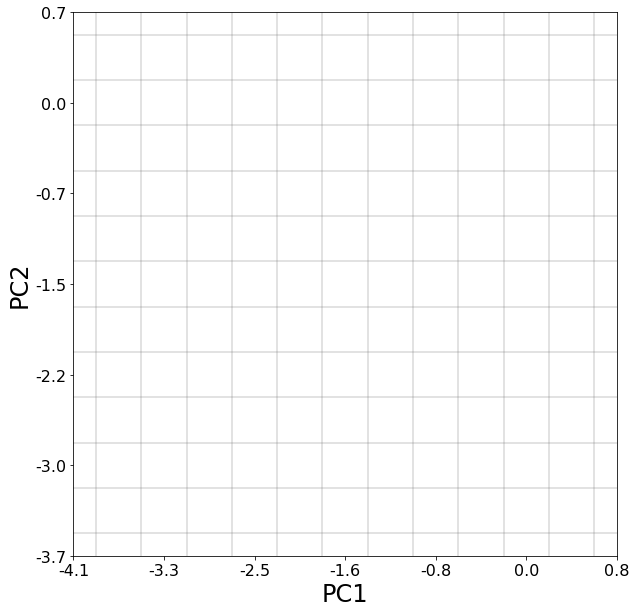

In [83]:
########## animate the PC transition trajectory 
########## DRAW THE LINE AS THROUGH TIME WITH COLOR CHANGE 
from CustomFunctions.PCvisualization import interpolate_transitions_by_distance

norm = matplotlib.colors.Normalize()
cmm = cm.dense




#get the interpolated points just in case I haven't calculated them yet
bintraj = data[['PC1bins','PC2bins']].to_numpy()


#interpolate the trajectory in the transition space
interarray = interpolate_transitions_by_distance(bintraj, 0.01)

#make fig
fig, ax = plt.subplots(figsize = (10,10))


#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines




ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticklabels([round(x,1) for x in centers.PC1.to_list()], fontsize = 16)
ax.set_yticklabels([round(x,1) for x in centers.PC2.to_list()], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


#normalize to the colors to the length of the trajectory
norm.autoscale([0,interarray[:,1].max()])

# create a point in the axes
# point, = ax.plot([],[])#, marker="o", color = '#eb4034', markersize = 15)
# scat = ax.scatter(interarray[:,2], interarray[:,3], color = cmm(norm(interarray[:,1])), edgecolor='none')
scat = ax.scatter(np.empty(len(interarray)), np.empty(len(interarray)), color = cmm(norm(interarray[:,1])), edgecolor='none')




# make function for updating point position
def animate(i, interarray):
    current = interarray.copy()
    #set the colors to the correct set
    scat.set_facecolor(cmm(norm(current[:,1])))
    #remove the datapoints that are in "the future"
    current[np.where(current[:,0]>(i-1))] = np.nan
    #set the current set of data
    scat.set_offsets(current[:,[2,3]])

    return scat,

#add two to the frame count to adjust the range function and to add a blank frame at the beginning
ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(int(max(interarray[:,0])+2))), fargs = (interarray,))
plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + '_plotanimation_PC1-PC2colorchange.mp4', fps=8, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


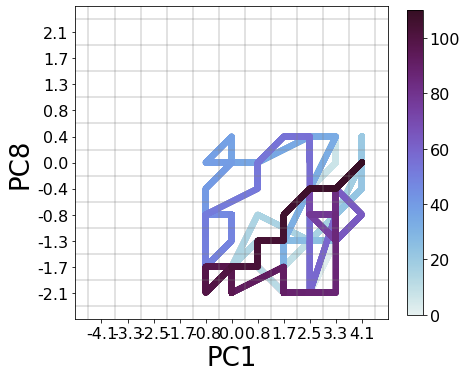

In [16]:
############## look at the entire transition trajectory for this cell #################

# #open interpolated transition data
# inter = pd.read_csv(savedir + 'interpolated_PC1-PC2_transitions.csv', index_col=0)
# interdata = inter[(inter.CellID==row.CellID) & (inter.frame.isin(row.actual_run))]

norm = matplotlib.colors.Normalize()
cmm = cm.dense


fig, ax = plt.subplots(figsize=(7,7))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = data.PC1bins.to_numpy()
py = data.PC8bins.to_numpy()
pz = data.frame.to_numpy()
dist = np.nansum(distance.pdist(data[['PC1bins','PC8bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
newz = np.arange(0,len(data), len(data)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,newz.max()])
#plot the actual transitions
ax.scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.25, edgecolors='none')


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 26)
ax.set_ylabel('PC8', fontsize = 26)
ax.set_xticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC1.to_list()], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round(x,1) for x in centers.PC8.to_list()], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

# #plot the interpolated transitions
# ix = np.append(interdata.from_x.to_numpy(), interdata.to_x.to_numpy()[-1])
# iy = np.append(interdata.from_y.to_numpy(), interdata.to_y.to_numpy()[-1])
# ax.plot(ix, iy, color ='black', alpha=0.2)


cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmm),shrink=0.8)
cb.ax.tick_params(labelsize=16)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
# plt.savefig(specificdir + 'entire_transition_trajectory.png', bbox_inches='tight')

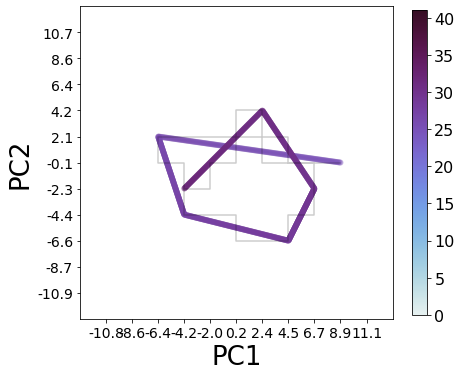

In [205]:
############## look at the SHORTER interpolated transition trajectory for this cell #################

#open interpolated transition data
inter = pd.read_csv(savedir + 'interpolated_PC1-PC2_transitions.csv', index_col=0)
interdata = inter[(inter.CellID==row.CellID) & (inter.frame.isin(row.actual_run))].sort_values(
    ['frame','cumulative_time']).reset_index(drop = True)

norm = matplotlib.colors.Normalize()
cmm = cm.dense


fig, ax = plt.subplots(figsize=(7,7))

# #add "grid lines" first 
# for h in np.linspace(0.5, nbins+0.5, nbins+1):
#     ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
#     ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

datrange = [25,32]
shortdat = data[datrange[0]:datrange[1]].copy()
shortint = pd.concat([interdata.loc[interdata['frame'].isin(range(datrange[0],datrange[1]-1))],
                      pd.DataFrame(interdata[interdata['frame']==datrange[1]-1].iloc[0]).T])

#interpolate along the trajectory so I can plot dots which will represent the color gradient line
px = shortdat.PC1bins.to_numpy()
py = shortdat.PC2bins.to_numpy()
pz = shortdat.frame.to_numpy()
dist = np.nansum(distance.pdist(shortdat[['PC1bins','PC2bins']]))
fx = interpolate.interp1d(np.arange(1,len(px)+1),px)
newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(15*dist)))
fy = interpolate.interp1d(np.arange(1,len(py)+1),py)
newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(15*dist)))
newz = np.arange(datrange[0],datrange[1], len(shortdat)/len(newy))
if len(newz)>len(newy):
    newz = newz[:-1]
#normalize to the colors to the length of the trajectory
norm.autoscale([0,len(data)])
#plot the actual transitions
ax.scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.4, edgecolors='none')


ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 26)
ax.set_ylabel('PC2', fontsize = 26)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 14)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 14)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#plot the interpolated transitions
ix = shortint.from_x.to_numpy()#np.append(shortint.from_x.to_numpy(), shortint.to_x.to_numpy()[-1])
iy = shortint.from_y.to_numpy()#np.append(shortint.from_y.to_numpy(), shortint.to_y.to_numpy()[-1])
ax.plot(ix, iy, color ='black', alpha=0.2)


cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmm),shrink=0.8)
cb.ax.tick_params(labelsize=16)

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
plt.savefig(specificdir + 'short_transition_trajectory.png', bbox_inches='tight')

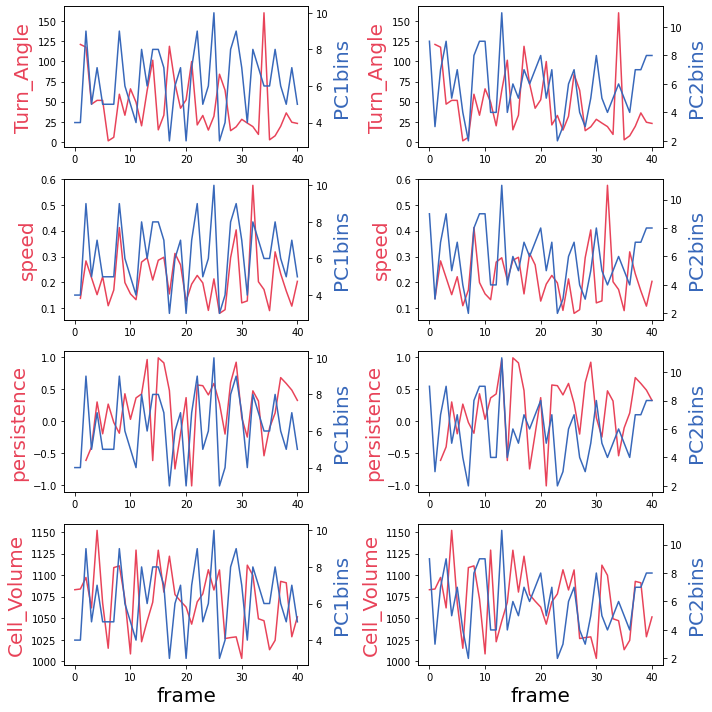

In [217]:
############# plot PC1 and PC2 over time separately ################

colors = ['#e84359','#3868ba']

whichpcs = [1,2]
metlist = [
    'Turn_Angle',
    'speed',
    'persistence',
    'Cell_Volume'
]

fig, axes = plt.subplots(len(metlist),len(whichpcs),figsize=(10,len(metlist)*2.5))
for a, ax in enumerate(axes):
    #plot metric in question
    for i, na in enumerate(ax):
        na.plot(data['frame'].to_numpy(), data[metlist[a]].to_numpy(), color = colors[0])
        na.set_ylabel(metlist[a], color=colors[0], fontsize=20)
        if a == len(axes)-1:
            na.set_xlabel('frame', fontsize = 20)
    #plot PCs in question
    for i, pc in enumerate(whichpcs):
        newax = ax[i].twinx()
        newax.plot(data['frame'].to_numpy(), data[f'PC{pc}bins'].to_numpy(), color = colors[1])
        newax.set_ylabel(f'PC{pc}bins', color=colors[1], fontsize=20)
    
plt.tight_layout()
#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
plt.savefig(specificdir + 'Metrics vs PCs through time.png', bbox_inches='tight')


In [98]:
data.speed

0           NaN
1      0.139624
2      0.165478
3      0.162066
4      0.093634
         ...   
101    0.062684
102    0.049250
103    0.044720
104    0.048377
105    0.065799
Name: speed, Length: 106, dtype: float64

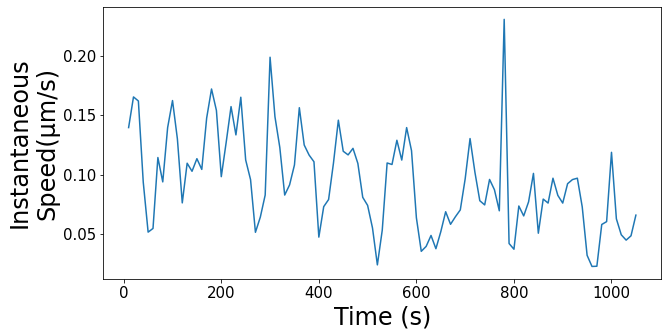

In [171]:
################# SINGLE ANIMATED METRICS ###############
########## animate the PC transition trajectory DRAW THE LINE AS THROUGH TIME ##############

metricstoplot = ['speed']

#make fig
fig, ax = plt.subplots(figsize = (10,5))

#establish time range
realtime = np.arange(len(data))*time_interval
#plot the initial line
ax.plot(realtime,data.speed)

movingdata = data.copy()[['frame']+metricstoplot]

# create a point in the axes
point, = ax.plot(realtime[0],data.speed[0], marker="o", color = '#eb4034', markersize = 10)



# make function for updating point position
def animate(i, dat):
    for c in dat.columns.to_list()[1:]:
        point.set_data([realtime[i]], [dat[c][i]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(movingdata))), fargs = (movingdata,))

ax.set_xlabel('Time (s)', fontsize = 24)#, labelpad = -1)
ax.set_ylabel('Instantaneous\nSpeed(μm/s)', fontsize = 24)#, labelpad = -1)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + 'Metric_animated_plot.mp4', fps=8, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


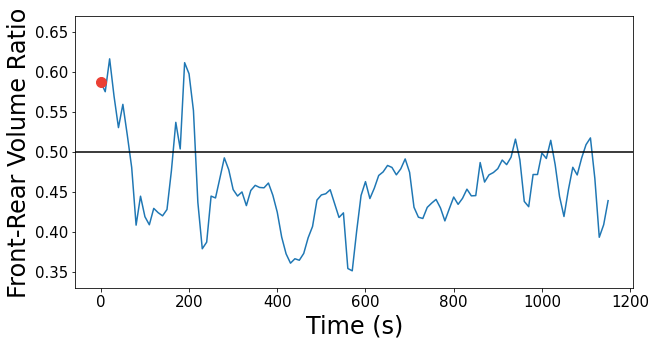

In [187]:
################# SINGLE ANIMATED METRICS ###############
########## animate the PC transition trajectory DRAW THE LINE AS THROUGH TIME ##############

metricstoplot = ['Volume_Front_Ratio']

#make fig
fig, ax = plt.subplots(figsize = (10,5))

#establish time range
realtime = np.arange(len(data))*time_interval
#plot the initial line
ax.plot(realtime,data[metricstoplot])
ax.axhline(0.5, color='black')
movingdata = data.copy()[['frame']+metricstoplot]

# create a point in the axes
point, = ax.plot(realtime[0],movingdata.Volume_Front_Ratio[0], marker="o", color = '#eb4034', markersize = 10)



# make function for updating point position
def animate(i, dat):
    for c in dat.columns.to_list()[1:]:
        point.set_data([realtime[i]], [dat[c][i]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(movingdata))), fargs = (movingdata,))

ax.set_xlabel('Time (s)', fontsize = 24)#, labelpad = -1)
ax.set_ylabel('Front-Rear Volume Ratio', fontsize = 24)#, labelpad = -1)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylim(0.33,0.67)
plt.show()

#make the directory to save this combined image
specificdir = infrsavedir + row.CellID +'/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
ani.save(specificdir + 'FR_animated_plot.mp4', fps=8, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


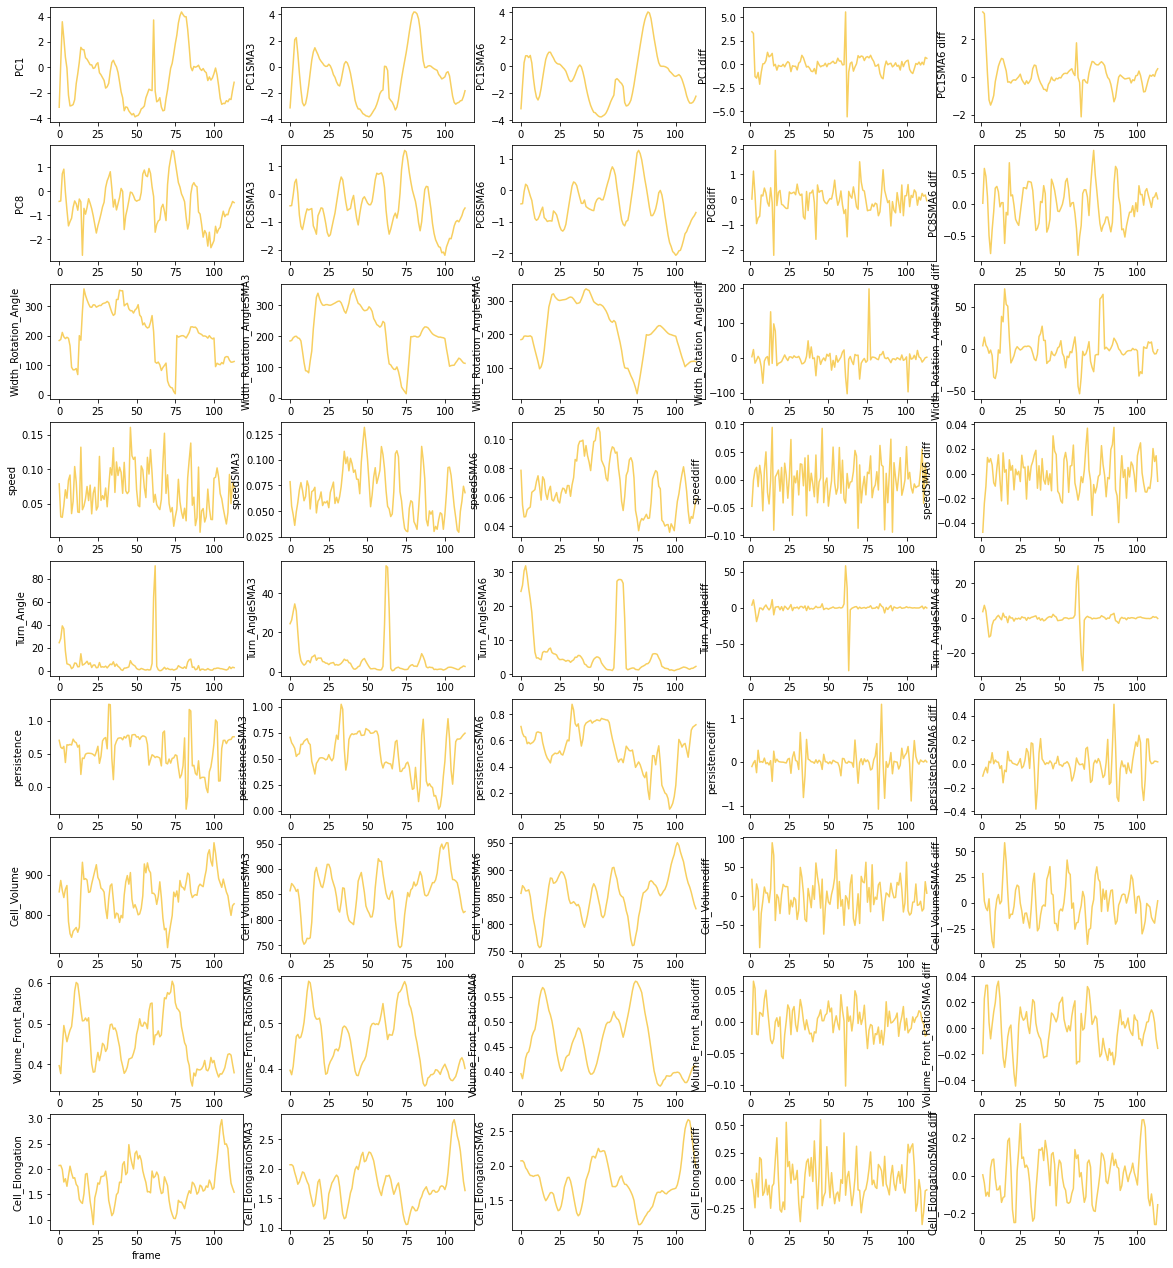

In [11]:
############# Plot a bunch of metrics over time ################
#add diff of PC1_PC2_cumulative_area_explored for rolling sum measure

metlist = [
    'PC1',
    'PC8',
    'Width_Rotation_Angle',
    'speed',
    'Turn_Angle',
    'persistence',
    'Cell_Volume',
    'Volume_Front_Ratio',
    'Cell_Elongation',
]

fig, axes = plt.subplots(len(metlist),5,figsize=(20,len(metlist)*2.5))
for a, ax in enumerate(axes):
    #plot metric in question
    
    ax[0].plot(data[metlist[a]].to_numpy(), color = '#f7cf60')
    ax[0].set_ylabel(metlist[a])#, color='#f7cf60')
    
    ax[1].plot(data[metlist[a]].rolling(3,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[1].set_ylabel(metlist[a]+'SMA3')#, color='#f7cf60')
    
    ax[2].plot(data[metlist[a]].rolling(6,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[2].set_ylabel(metlist[a]+'SMA6')#, color='#f7cf60')
    
    ax[3].plot(data[metlist[a]].diff().to_numpy(), color = '#f7cf60')
    ax[3].set_ylabel(metlist[a]+'diff')#, color='#f7cf60')
    
    ax[4].plot(data[metlist[a]].diff().rolling(3,min_periods=1).mean().to_numpy(), color = '#f7cf60')
    ax[4].set_ylabel(metlist[a]+'SMA6 diff')#, color='#f7cf60')
    
    
    if a == len(axes)-1:
        ax[0].set_xlabel('frame')
        

In [12]:
data.columns.to_list()

['cell',
 'Euler_angles_X',
 'Euler_angles_Y',
 'Euler_angles_Z',
 'Width_Rotation_Angle',
 'Cell_Centroid_X',
 'Cell_Centroid_Y',
 'Cell_Centroid_Z',
 'Cell_Volume',
 'Cell_Volume_Front',
 'Cell_Volume_Right',
 'Cell_Volume_Top',
 'Cell_SurfaceArea',
 'Cell_MajorAxis',
 'Cell_MajorAxis_Vec_X',
 'Cell_MajorAxis_Vec_Y',
 'Cell_MajorAxis_Vec_Z',
 'Cell_MinorAxis',
 'Cell_MinorAxis_Vec_X',
 'Cell_MinorAxis_Vec_Y',
 'Cell_MinorAxis_Vec_Z',
 'Cell_MiniAxis',
 'Cell_MiniAxis_Vec_X',
 'Cell_MiniAxis_Vec_Y',
 'Cell_MiniAxis_Vec_Z',
 'OriginaltoReconError',
 'RecontoOriginalError',
 'shcoeffs_L0M0C',
 'shcoeffs_L0M1C',
 'shcoeffs_L0M2C',
 'shcoeffs_L0M3C',
 'shcoeffs_L0M4C',
 'shcoeffs_L0M5C',
 'shcoeffs_L0M6C',
 'shcoeffs_L0M7C',
 'shcoeffs_L0M8C',
 'shcoeffs_L0M9C',
 'shcoeffs_L0M10C',
 'shcoeffs_L1M0C',
 'shcoeffs_L1M1C',
 'shcoeffs_L1M2C',
 'shcoeffs_L1M3C',
 'shcoeffs_L1M4C',
 'shcoeffs_L1M5C',
 'shcoeffs_L1M6C',
 'shcoeffs_L1M7C',
 'shcoeffs_L1M8C',
 'shcoeffs_L1M9C',
 'shcoeffs_L1M10C',


In [28]:
from scipy import signal

corr = signal.correlate(data['Turn_Angle'], data['PC2bins'])
lags = signal.correlation_lags(len(data['Turn_Angle']), len(data['PC2bins']))
corr /= np.max(corr)

ValueError: cannot convert float NaN to integer

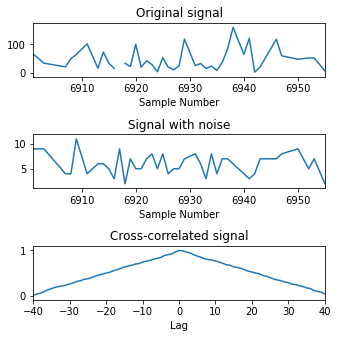

In [29]:
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(data['Turn_Angle'])
ax_orig.set_title('Original signal')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(data['PC2bins'])
ax_noise.set_title('Signal with noise')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [27]:
lags[40]

0